In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import re
import spacy
spacy.cli.download('fr_core_news_sm')
nlp = spacy.load('fr_core_news_sm')
import  nltk
print(nltk.__version__)

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
3.7


In [3]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
import keras.utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalMaxPool1D
from keras.layers import LSTM
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras import Model
from keras.utils import to_categorical
from keras.utils import pad_sequences 

#Importing the french song dataset

In [5]:
with open ('/content/drive/MyDrive/Progetto_TA_2022/pickled_df/df_fr.pkl', mode='br') as inputfile:
  df_fr = pickle.load(inputfile)

In [6]:
df_fr.shape

(644, 5)

Data cleaning and exploring

In [7]:
df_fr = df_fr.reset_index()
df_fr = df_fr.drop(['index'], axis = 1)

In [8]:
df_fr

,Artist,Song,Genre,Language,Lyrics
0,bad religion,new america (bass tab),Pop,fr,intro x g d a e verse g d a e pre chorus x p=p...
1,blink 182,asthenia (tablatura),Pop,fr,drop d tuning intro verse dist x x x x x x x ...
2,blondie,sunday girl (french version),Pop,fr,je connais une fille dans une rue déserte froi...
3,blondie,le bleu,Pop,fr,amène toi johnny emmène moi johnny tous ces go...
4,blondie,sunday girl (french version),Pop,fr,je connais une fille dans une rue déserte froi...
...,...,...,...,...,...
639,alain souchon,18 ans que je t'ai a l'oeil,Pop,fr,dix huit ans que je t ai a l oeil t es a bagne...
640,alain souchon,loulou doux,Pop,fr,j veux bien l blouson pas l canif j veux bien ...
641,alcest,le miroir,Metal,fr,je suis une image dans l ombre un lieu vagueme...
642,dusty springfield,je ne peux pas t en vouloir,Pop,fr,springfield westlake gerald french version of...


#Splitting the dataset in training set and test set

In [9]:
import sklearn
from sklearn.model_selection import train_test_split

In [10]:
fr_train, fr_test = sklearn.model_selection.train_test_split(df_fr, test_size=0.20, train_size=0.80)

In [11]:
fr_train.shape, fr_test.shape

((515, 5), (129, 5))

In [12]:
df_fr['Genre'].value_counts() 

Pop      388
Rock     199
Metal     23
Jazz      18
Folk      14
Indie      2
Name: Genre, dtype: int64

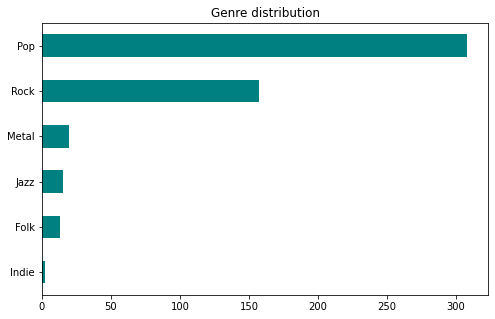

In [13]:
plt.rcParams['figure.figsize'] = [8,5]
x = fr_train['Genre'].value_counts().sort_values(ascending = True)
plt.title("Genre distribution")
x.plot(kind ='barh', color="teal")

#Tokenizing the lyrics with spacy

In [14]:
x_train = fr_train['Lyrics'].tolist()
y_train = fr_train['Genre'].tolist()

In [15]:
x_test = fr_test['Lyrics'].tolist()
y_test = fr_test['Genre'].tolist()

In [16]:
len(x_train), len(y_train), len(x_test), len(y_test)

(515, 515, 129, 129)

In [17]:
set(y_train)

{'Folk', 'Indie', 'Jazz', 'Metal', 'Pop', 'Rock'}

In [18]:
sample_idx = 80
x_train[sample_idx]

'dors ma mie dehors la nuit est noire dors ma mie bonsoir dors ma mie c est notre dernier soir dors ma mie bonsoir sur les fleurs qui ferment leurs paupieres pleure la pluie legere et l oiseau qui chantera l aurore dors et reve encor ainsi demain deja serai seul a nouveau et tu m auras perdu rien qu en me voulant trop tu m auras gaspille a te vouloir batir un bonheur eternel ennuyeux a perir au lieu de te pencher vers moi tout simplement moi qui avais besoin si fort de ton printemps non les filles que l on aime ne comprendront jamais qu elles sont a chaque fois notre dernier muguet notre derniere chance notre dernier sursaut notre dernier depart notre dernier bateau dors ma mie dehors la nuit est noire dors ma mie bonsoir dors ma mie c est notre dernier soir dors ma mie je pars'

In [19]:
y_train[sample_idx]

'Rock'

In [20]:
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

stopword_list = stopwords.words('french')
punctuations = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [21]:
def spacy_tokenizer (text):
   
    doc = nlp(text)

    #lemmatizing tokens and lowering case
    lemmas = [token.lemma_.lower() for token in doc]

    #removing stopwords and punctuations
    lemmas_stop= [token for token in lemmas if token not in stopword_list and token not in punctuations]  

    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas_stop,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas_stop,3)] 
    
    all_tokens = list()
    all_tokens.extend(lemmas_stop)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    return all_tokens

#Token vectorization with CountVectorizer and spacy_tokenizer function above

In [22]:
vectors = CountVectorizer (analyzer = spacy_tokenizer, min_df = 5)

In [23]:
print ('fit')
vectors.fit(x_train)
print('transform')
x_train_tok = vectors.transform(x_train)
x_test_tok = vectors.transform(x_test)
print ('done')

fit
transform
done


In [24]:
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/fr_x_train_tok.pkl', 'wb') as outfile:
  pickle.dump(x_train_tok, outfile)
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/fr_x_test_tok.pkl', 'wb') as outfile:
  pickle.dump(x_test_tok, outfile)

In [25]:
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/fr_x_train_tok.pkl', mode = 'br') as infile:
  x_train_tok = pickle.load(infile)
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/fr_x_test_tok.pkl', mode = 'br') as infile:
  x_test_tok = pickle.load(infile)

In [26]:
len(vectors.vocabulary_)

2522

In [27]:
vectors.vocabulary_

{'ciel': 1170,
 'bleu': 1064,
 'pouvoir': 2043,
 'terre': 2333,
 'bien': 1051,
 'peu': 1981,
 'importe': 1621,
 'si': 2241,
 'taire': 2309,
 'aimer': 922,
 'foutre': 1487,
 'monde': 1810,
 'entier': 1383,
 'tant': 2313,
 'amour': 946,
 'matin': 1759,
 'corps': 1212,
 'main': 1733,
 'puisque': 2079,
 'irai': 1634,
 'jusqu': 1658,
 'bout': 1082,
 'faire': 1428,
 'blonde': 1065,
 'aller': 934,
 'lune': 1717,
 'voler': 2460,
 'demain': 1275,
 'ami': 944,
 'demander': 1277,
 'rir': 2169,
 'quoi': 2099,
 'jour': 1654,
 'vie': 2430,
 'meur': 1784,
 'être': 2520,
 'loin': 1704,
 'car': 1112,
 'mourir': 1826,
 'aussi': 989,
 'avoir': 1006,
 'tout': 2369,
 'plus': 2014,
 'problème': 2064,
 'croire': 1244,
 'aime': 921,
 'dieu': 1298,
 'celui': 1126,
 'BI_peu_importe': 446,
 'BI_si_taire': 531,
 'BI_taire_aimer': 546,
 'BI_monde_entier': 386,
 'BI_jusqu_bout': 349,
 'BI_importe_quoi': 332,
 'BI_être_loin': 718,
 'BI_taire_aime': 545,
 'BI_celui_aimer': 187,
 'étoile': 2517,
 'nom': 1862,
 'lettre

#SVM Classification

---



---



Classification report:
              precision    recall  f1-score   support

        Folk       0.00      0.00      0.00         1
        Jazz       0.75      1.00      0.86         3
       Metal       0.00      0.00      0.00         3
         Pop       0.69      0.85      0.76        80
        Rock       0.56      0.36      0.43        42

    accuracy                           0.67       129
   macro avg       0.40      0.44      0.41       129
weighted avg       0.63      0.67      0.64       129

Confusion matrix:
[[ 0  0  0  1  0]
 [ 0  3  0  0  0]
 [ 0  0  0  2  1]
 [ 0  1  0 68 11]
 [ 0  0  0 27 15]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


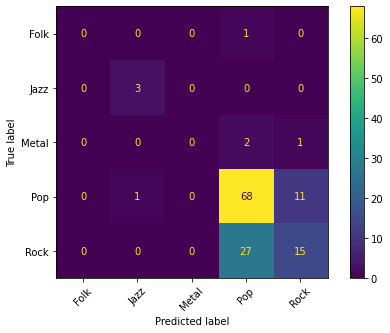

In [28]:
svm_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(x_train,y_train)
predictions = svm_pipeline.predict(x_test)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

ConfusionMatrixDisplay.from_estimator(svm_pipeline, x_test, y_test)  
plt.xticks(rotation=45)
plt.show()

SVM classification with tokenized lyrics - no optimization

Classification report:
              precision    recall  f1-score   support

        Folk       0.00      0.00      0.00         1
        Jazz       0.75      1.00      0.86         3
       Metal       0.00      0.00      0.00         3
         Pop       0.70      0.89      0.78        80
        Rock       0.62      0.36      0.45        42

    accuracy                           0.69       129
   macro avg       0.42      0.45      0.42       129
weighted avg       0.66      0.69      0.65       129

Confusion matrix:
[[ 0  0  0  1  0]
 [ 0  3  0  0  0]
 [ 0  0  0  2  1]
 [ 0  1  0 71  8]
 [ 0  0  0 27 15]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


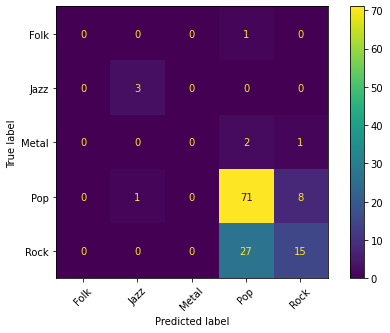

In [29]:
svm_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(x_train_tok,y_train)
predictions = svm_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

ConfusionMatrixDisplay.from_estimator(svm_pipeline, x_test_tok, y_test)  
plt.xticks(rotation=45)
plt.show()

SVM classification with tokenized lyrics and optimized parameters

In [30]:
opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

param_grid = [{'sel__k': [50, 100, 250,'all'], 'learner__C': [0.01, 0.1, 1, 10, 100]}]
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, cv=None, n_jobs = 3, verbose=True).fit(x_train_tok,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [31]:
SVM_opt_search.best_params_

{'learner__C': 100, 'sel__k': 'all'}

In [32]:
SVM_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x7f58c9467830>)),
                ('tfidf', TfidfTransformer()), ('learner', LinearSVC(C=100))])

In [33]:
opt_predictions = SVM_opt_search.best_estimator_.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

        Folk       0.00      0.00      0.00         1
        Jazz       0.75      1.00      0.86         3
       Metal       0.00      0.00      0.00         3
         Pop       0.74      0.80      0.77        80
        Rock       0.54      0.48      0.51        42

    accuracy                           0.67       129
   macro avg       0.41      0.46      0.43       129
weighted avg       0.65      0.67      0.66       129

Confusion matrix:
[[ 0  0  0  1  0]
 [ 0  3  0  0  0]
 [ 0  0  0  1  2]
 [ 0  1  0 64 15]
 [ 1  0  0 21 20]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features that weight more on classification:

In [34]:
tokenizer = vectors
selector = svm_pipeline.named_steps['sel']
classifier = svm_pipeline.named_steps['learner']

In [35]:
feature_names = tokenizer.get_feature_names_out()
feats_w_score = list()
for index,(selected,score) in enumerate(zip(selector.get_support(),selector.scores_)):
    feats_w_score.append((score,selected,feature_names[index]))
feats_w_score = sorted(feats_w_score)
len(feats_w_score)

2522

In [36]:
feats_w_score[:100],feats_w_score[-100:]

([(0.6339440813963106, True, 'BI_air_avoir'),
  (0.6339440813963106, True, 'BI_aller_casser'),
  (0.6339440813963106, True, 'BI_autre_être'),
  (0.6339440813963106, True, 'BI_avoir_finir'),
  (0.6339440813963106, True, 'BI_car_tout'),
  (0.6339440813963106, True, 'BI_faire_faire'),
  (0.6339440813963106, True, 'BI_falloir_mettre'),
  (0.6339440813963106, True, 'BI_quitte_avoir'),
  (0.6339440813963106, True, 'BI_tout_mec'),
  (0.6339440813963106, True, 'BI_veux_savoir'),
  (0.6339440813963106, True, 'TRI_tout_monde_être'),
  (0.6339440813963106, True, 'cas'),
  (0.6339440813963106, True, 'changent'),
  (0.6339440813963106, True, 'chier'),
  (0.6339440813963106, True, 'course'),
  (0.6339440813963106, True, 'desert'),
  (0.6339440813963106, True, 'espere'),
  (0.6339440813963106, True, 'gramme'),
  (0.6339440813963106, True, 'marseille'),
  (0.6339440813963106, True, 'moitie'),
  (0.6339440813963106, True, 'mordre'),
  (0.6339440813963106, True, 'plupart'),
  (0.6339440813963106, True, 

In [37]:
feats_w_classifier_weight = list()
for index,weight in enumerate(selector.inverse_transform(classifier.coef_)[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

2487

In [38]:
feats_w_classifier_weight[:100]

[(-0.5545409461898791, 'être'),
 (-0.3504988800838496, 'monde'),
 (-0.3360921538590423, 'aime'),
 (-0.27234819870690263, 'avoir'),
 (-0.24373426834972522, 'montagne'),
 (-0.23658061166792377, 'main'),
 (-0.23009566838493173, 'importe'),
 (-0.2279866280961749, 'enfant'),
 (-0.22440617889427963, 'you'),
 (-0.2238585110935115, 'ici'),
 (-0.22097389033525963, 'comment'),
 (-0.22093347855603102, 'vouloir'),
 (-0.2202553319418462, 'jusqu'),
 (-0.21992703126833135, 'comme'),
 (-0.21955327769744837, 'dis'),
 (-0.2176195049995681, 'moment'),
 (-0.21210056963815083, 'croire'),
 (-0.20770394027652356, 'quand'),
 (-0.2076487970079166, 'oui'),
 (-0.20659470145813588, 'voir'),
 (-0.20161863256832252, 'rein'),
 (-0.19998555918162453, 'où'),
 (-0.19677811828474512, 'oublier'),
 (-0.18912703790421023, 'cela'),
 (-0.18860390859391907, 'pleurer'),
 (-0.17914645533906062, 'tant'),
 (-0.17858430489722146, 'loin'),
 (-0.17109389752102364, 'mere'),
 (-0.1668835855997206, 'garde'),
 (-0.16333068199345763, 'vo

#Naïve Bayes Classification

---



---



In [39]:
NBC_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

NBC_pipeline.fit(x_train_tok,y_train)
predictions = NBC_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

        Folk       0.00      0.00      0.00         1
        Jazz       0.60      1.00      0.75         3
       Metal       0.00      0.00      0.00         3
         Pop       0.74      0.74      0.74        80
        Rock       0.49      0.48      0.48        42

    accuracy                           0.64       129
   macro avg       0.37      0.44      0.39       129
weighted avg       0.63      0.64      0.63       129

Confusion matrix:
[[ 0  0  0  1  0]
 [ 0  3  0  0  0]
 [ 0  0  0  0  3]
 [ 2  1  0 59 18]
 [ 0  1  1 20 20]]


#Decision Tree Classification

---



---



In [40]:
dt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', DecisionTreeClassifier())  # learning algorithm
])

dt_pipeline.fit(x_train_tok,y_train)
predictions = dt_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

        Folk       0.00      0.00      0.00         1
       Indie       0.00      0.00      0.00         0
        Jazz       0.60      1.00      0.75         3
       Metal       0.00      0.00      0.00         3
         Pop       0.71      0.76      0.73        80
        Rock       0.50      0.38      0.43        42

    accuracy                           0.62       129
   macro avg       0.30      0.36      0.32       129
weighted avg       0.62      0.62      0.61       129

Confusion matrix:
[[ 0  0  0  0  1  0]
 [ 0  0  0  0  0  0]
 [ 0  0  3  0  0  0]
 [ 0  0  0  0  3  0]
 [ 1  1  1  0 61 16]
 [ 4  0  1  0 21 16]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

#Random Forest Classification

---



---



In [41]:
RF_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier())  # learning algorithm
])

RF_pipeline.fit(x_train_tok,y_train)
predictions = RF_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

        Folk       0.00      0.00      0.00         1
        Jazz       0.75      1.00      0.86         3
       Metal       0.00      0.00      0.00         3
         Pop       0.71      0.95      0.81        80
        Rock       0.82      0.33      0.47        42

    accuracy                           0.72       129
   macro avg       0.46      0.46      0.43       129
weighted avg       0.73      0.72      0.68       129

Confusion matrix:
[[ 0  0  0  1  0]
 [ 0  3  0  0  0]
 [ 0  0  0  2  1]
 [ 1  1  0 76  2]
 [ 0  0  0 28 14]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#LSTM Classification 

---



---



In [42]:
fr_train['Genre_number'] = fr_train['Genre'] #converting the strings into int in the Genre column

numbers = []
for i in fr_train['Genre']:
  if i == 'Rock':
    numbers.append(0)
  
  if i == 'Pop':
    numbers.append(1)
   
  if i == 'Metal':
    numbers.append(2)
    
  if i == 'Jazz':
    numbers.append(3)

  if i == 'Folk':
   numbers.append(4)
  
  elif i == 'Indie':
   numbers.append(5)

  
  
  

In [43]:
fr_train['Genre_number'] = numbers

In [44]:
fr_test['Genre_number'] = fr_test['Genre'] #converting the strings into int in the Genre column

numbers_test = []
for i in fr_test['Genre']:
  if i == 'Rock':
    numbers_test.append(0)
  
  if i == 'Pop':
    numbers_test.append(1)
   
  if i == 'Metal':
    numbers_test.append(2)
    
  if i == 'Jazz':
    numbers_test.append(3)

  if i == 'Folk':
   numbers_test.append(4)
  
  elif i == 'Indie':
   numbers_test.append(5)
  

  
  

In [45]:
fr_test['Genre_number'] = numbers_test

In [46]:
fr_train.sample(5)

,Artist,Song,Genre,Language,Lyrics,Genre_number
643,celtic woman,panis angelicus,Folk,fr,panis angelicus fit panis hominum dat panis co...,4
390,michel sardou,vladimir ilitch,Pop,fr,un vent de sibrie souffle sur la bohme les fem...,1
428,stan getz,autumn leaves,Jazz,fr,the falling leaves drift by the window the aut...,3
535,booba,jour de paye,Pop,fr,moi j ai fait la guerre pour habiter rue de la...,1
559,"brel, jacques",la haine,Rock,fr,comme un marin je partirai pour aller rire che...,0


In [47]:
fr_test.sample(5)

,Artist,Song,Genre,Language,Lyrics,Genre_number
106,britney spears,coupure électrique,Pop,fr,j oublie le monde quand tu fais fais moi l amo...,1
0,bad religion,new america (bass tab),Pop,fr,intro x g d a e verse g d a e pre chorus x p=p...,1
206,celine dion,moi quand je pleure,Pop,fr,une petite fille abandonnée un oiseau blessé u...,1
307,tiziano ferro,imbranato ( french/ italian version),Pop,fr,tatoué sur ma peau comme la fleur de lys ton d...,1
602,"brel, jacques",jojo,Rock,fr,jojo voici donc quelques rires quelques vins q...,0


In [48]:
y_train = fr_train['Genre_number'] #substituting the columns in the variables
y_test = fr_test['Genre_number']

In [49]:
y_train = to_categorical(y_train,6)  #converting to one-hot vectors
y_test = to_categorical(y_test, 6)

In [50]:
y_train.shape, y_test.shape

((515, 6), (129, 6))

In [52]:
#max number of words to be used
max_features = 20000
#max number of words in each lyrics
maxlen = 200
#fixed size
embed_size = 128

batch_size = 64
epochs = 10

tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [54]:
X_train_final.shape, y_train.shape

((515, 200), (515, 6))

In [55]:
X_test_final.shape, y_test.shape

((129, 200), (129, 6))

In [56]:
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(LSTM(20, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 20)                11920     
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 32)                672       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 2,572,790
Trainable params: 2,572,790
Non-

In [57]:
lstm = model.fit(X_train_final, y_train,
                 batch_size=batch_size, 
                 epochs=epochs, 
                 shuffle = True, 
                 validation_split=0.2, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
lstm

Epoch 1/10
7/7 [==============================] - 8s 574ms/step - loss: 1.7581 - accuracy: 0.4757 - val_loss: 1.6809 - val_accuracy: 0.5534
Epoch 2/10
7/7 [==============================] - 2s 339ms/step - loss: 1.5971 - accuracy: 0.6092 - val_loss: 1.5039 - val_accuracy: 0.5534
Epoch 3/10
7/7 [==============================] - 2s 341ms/step - loss: 1.4219 - accuracy: 0.6092 - val_loss: 1.3539 - val_accuracy: 0.5534
Epoch 4/10
7/7 [==============================] - 2s 337ms/step - loss: 1.2877 - accuracy: 0.6092 - val_loss: 1.2512 - val_accuracy: 0.5534
Epoch 5/10
7/7 [==============================] - 2s 355ms/step - loss: 1.1829 - accuracy: 0.6092 - val_loss: 1.1854 - val_accuracy: 0.5534
Epoch 6/10
7/7 [==============================] - 2s 337ms/step - loss: 1.1324 - accuracy: 0.6092 - val_loss: 1.1467 - val_accuracy: 0.5534
Epoch 7/10
7/7 [==============================] - 2s 316ms/step - loss: 1.1130 - accuracy: 0.6068 - val_loss: 1.1212 - val_accuracy: 0.5534
Epoch 8/10
7/7 [====

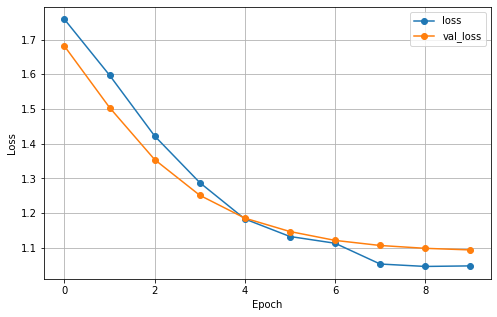

In [58]:
plt.plot(lstm.history['loss'], label='loss', marker = 'o')
plt.plot(lstm.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM Classification

In [59]:
lstm_pred= np.round(model.predict(X_test_final))

5/5 [==============================] - 0s 31ms/step


In [60]:
print('Accuracy %s' % accuracy_score(y_test, lstm_pred))
print('F1-score %s' % f1_score(y_test, lstm_pred, average=None))
print('Classification report:')
print(classification_report(y_test, lstm_pred))

Accuracy 0.6201550387596899
F1-score [0.         0.76555024 0.         0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.62      1.00      0.77        80
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62       129
   macro avg       0.10      0.17      0.13       129
weighted avg       0.38      0.62      0.47       129
 samples avg       0.62      0.62      0.62       129



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#CNN Classification

In [61]:
#max number of words to be used
max_features = 20000
#max number of words in each lyrics
maxlen = 200
#fixed size
embed_size = 128

batch_size = 64
epochs = 20
filters = 10
kernel_size = 3
hidden_dims = 10

tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [62]:
X_train_final[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    5,  157,
        574,   43,   47,  136,   36, 6644,    7,    1,  137,  136,   63,
         36, 6645,  117,   29,  319,   38,   14,   29,  368,    3,   25,
        357,   40,   81, 1040,  104,   27,   10,   49, 6646, 1769,   50,
       2744,  104,   11,   28,  200, 6647, 6648,   77,  264,  117,   29,
       4356,    6, 6649,   28,   49,  594,   14,   29,  368,    4, 3386,
        129,   35,  210,  909,   81,    3,   25, 1420, 4357,   19, 2344,
         38,   14,   25,    5, 3387,    4, 3386, 2745,    1,  454,    4,
       3386,  529,    1, 2746,   38,   14,   25,    5, 4358,    3, 4359,
         32, 3388,    3, 4359,   50,  483,   38,   14,   25,    5, 3387,
         16,  136,   63,  455,    2,   24,    3, 1420,   33,  319,  196,
         38,   14,   25,    5, 3387,   38,   13,   88,    1,   58,   15,
       3389,   44,   24,   38,   14, 2345,   11,   

In [63]:
model = Sequential()

model.add(Embedding(max_features, embed_size))
model.add(Dropout(0.4))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

#vanilla dense layer
model.add(Dense(15))
model.add(Dropout(0.4))
model.add(Activation('relu'))

#output layer
model.add(Dense(6))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 10)          3850      
                                                                 
 global_max_pooling1d (Globa  (None, 10)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 15)                165       
                                                                 
 dropout_3 (Dropout)         (None, 15)                0         
                                                      

In [64]:
cnn= model.fit(X_train_final, y_train, 
          batch_size = batch_size, 
          epochs=30, 
          shuffle=True, 
          validation_split=0.1,
          callbacks= [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/30
8/8 [==============================] - 2s 119ms/step - loss: 1.7550 - accuracy: 0.1836 - val_loss: 1.6888 - val_accuracy: 0.4038
Epoch 2/30
8/8 [==============================] - 1s 111ms/step - loss: 1.6355 - accuracy: 0.2765 - val_loss: 1.6022 - val_accuracy: 0.4038
Epoch 3/30
8/8 [==============================] - 1s 105ms/step - loss: 1.5572 - accuracy: 0.3110 - val_loss: 1.5094 - val_accuracy: 0.3846
Epoch 4/30
8/8 [==============================] - 1s 155ms/step - loss: 1.4635 - accuracy: 0.3175 - val_loss: 1.4181 - val_accuracy: 0.4423
Epoch 5/30
8/8 [==============================] - 1s 162ms/step - loss: 1.4159 - accuracy: 0.3693 - val_loss: 1.3459 - val_accuracy: 0.3654
Epoch 6/30
8/8 [==============================] - 2s 214ms/step - loss: 1.3528 - accuracy: 0.4298 - val_loss: 1.2942 - val_accuracy: 0.5385
Epoch 7/30
8/8 [==============================] - 1s 175ms/step - loss: 1.2794 - accuracy: 0.4708 - val_loss: 1.2552 - val_accuracy: 0.5192
Epoch 8/30
8/8 [====

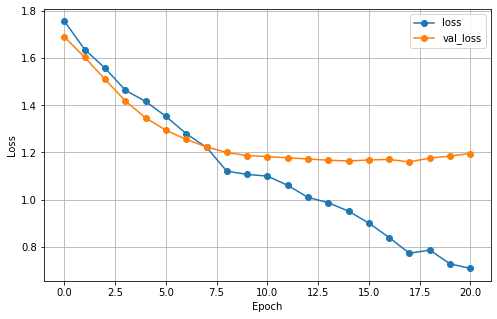

In [65]:
plt.plot(cnn.history['loss'], label='loss', marker = 'o')
plt.plot(cnn.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN Classification

In [66]:
cnn_pred= np.round(model.predict(X_test_final))

5/5 [==============================] - 0s 7ms/step


In [67]:
print('Accuracy %s' % accuracy_score(y_test, cnn_pred))
print('F1-score %s' % f1_score(y_test, cnn_pred, average=None))
print('Classification report:')
print(classification_report(y_test, cnn_pred, zero_division=1))

Accuracy 0.627906976744186
F1-score [0.17391304 0.79792746 0.         0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.10      0.17        42
           1       0.68      0.96      0.80        80
           2       1.00      0.00      0.00         3
           3       1.00      0.00      0.00         3
           4       1.00      0.00      0.00         1
           5       1.00      1.00      1.00         0

   micro avg       0.69      0.63      0.66       129
   macro avg       0.95      0.34      0.33       129
weighted avg       0.80      0.63      0.55       129
 samples avg       0.72      0.63      0.63       129



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


#Classification with Word2Vec

In [68]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [69]:
pip install --upgrade gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [70]:
import gensim
from gensim.models import Word2Vec

In [71]:
df_fr['Genre_number'] = df_fr['Genre'] #converting the strings into int in the Genre column

numbers = []
for i in df_fr['Genre']:
  if i == 'Rock':
    numbers.append(0)
  
  if i == 'Pop':
    numbers.append(1)
   
  if i == 'Metal':
    numbers.append(2)
    
  if i == 'Jazz':
    numbers.append(3)

  if i == 'Folk':
   numbers.append(4)
  
  elif i == 'Indie':
   numbers.append(5)
  
 
  

In [72]:
df_fr['Genre_number'] = numbers

In [73]:
#Gensim word2vec requires sentences in input so i split the lyrics into sentences
sentence_splitter = nltk.data.load('tokenizers/punkt/french.pickle')
sentences =[]
sum=0
for lyrics in df_fr['Lyrics']:
  sents = sentence_splitter.tokenize(lyrics.strip())
  sum+=len(sents)
  for sent in sents:
    sentences.append(sent.split())
print(sum)
print(len(sentences))

644
644


In [74]:
#checking that the sentences are in the correct format
for sent in sentences[:5]:
  print(sent, "\n")

['intro', 'x', 'g', 'd', 'a', 'e', 'verse', 'g', 'd', 'a', 'e', 'pre', 'chorus', 'x', 'p=pause', 'g', 'd', 'a', 'p', 'p', 'p', 'e', 'p', 'chorus', 'x', 'g', 'd', 'a', 'e', 'intro', 'x', 'verse', 'pre', 'chorus', 'x', 'chorus', 'x', 'intro', 'x', 'verse', 'pre', 'chorus', 'x', 'chorus', 'x', 'ending', 'g', 'd', 'a', 'e'] 

['drop', 'd', 'tuning', 'intro', 'verse', 'dist', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'bridge', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'pm', 'chorus', 'chorus', 'interlude', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'xx', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'xx', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'pm', 'pm', 'pm', 'pm', 'pm', 'pm', 'outro', 'x', 

In [75]:
#creating the w2v embeddings
w2v_model=gensim.models.Word2Vec(sentences=sentences, vector_size=300, window=10, min_count=1)

In [76]:
w2v_model.train(sentences, epochs=10, total_examples=len(sentences))

(1353336, 1799030)

In [77]:
#total num of extracted words
vocab = w2v_model.wv.index_to_key
print("Total number of words: ", len(vocab))

Total number of words:  14384


In [78]:
w2v_model.wv.most_similar('fille')

[('petite', 0.8886749148368835),
 ('cette', 0.8488840460777283),
 ('cheminée', 0.7703878283500671),
 ('princesse', 0.7617834806442261),
 ('aubepine', 0.7578653693199158),
 ('douce', 0.7564574480056763),
 ('meuf', 0.7509334683418274),
 ('porte', 0.7439252734184265),
 ('réchauffer', 0.7363039255142212),
 ('flamme', 0.7361845970153809)]

In [79]:
#creating a dictionary with words in vocab and their embeddings. It will be used to create the embedding matrix 

word_vec_dict={}

for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)

len(word_vec_dict)

14384

In [80]:
#finding the max length of the lyrics
maxi = -1
for i, lyrics in enumerate(df_fr['Lyrics']):
  tokens=lyrics.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)

print(maxi)

1886


In [81]:
#integer encoding the words in the lyrics using Keras Tokenizer
tok=Tokenizer()
tok.fit_on_texts(df_fr['Lyrics'])
vocab_size = len(tok.word_index) +1
encoded_lyrics = tok.texts_to_sequences(df_fr['Lyrics'])

In [82]:
max_lyrics_len=maxi
embed_dim = 300

#padding every sequence to the max length
padded_lyrics=pad_sequences(encoded_lyrics, maxlen=max_lyrics_len, padding='post')
padded_lyrics.shape

(644, 1886)

In [83]:
#creating the embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word, i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None: #if the word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
    #if the word is not found, the vector corresponding to the embedding will be filled with zeros

In [84]:
Y= to_categorical(df_fr['Genre_number'], 6) #transforming the labels into one hot vectors
x_train,x_test,y_train,y_test=train_test_split(padded_lyrics, Y,test_size=0.20,random_state=42)

In [85]:
y_train.shape, y_test.shape

((515, 6), (129, 6))

#LSTM Classification with Word2Vec

In [86]:
from keras.initializers import Constant


In [87]:
epochs=10
batch_size=64

In [88]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_lyrics_len, trainable=False, embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(20, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1886, 300)         4315500   
                                                                 
 lstm_1 (LSTM)               (None, 20)                25680     
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                672       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 4,342,050
Trainable params: 26,550
Non-t

In [89]:
lstm_w2v = model.fit(x_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle = True, 
                     validation_split=0.2, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
7/7 [==============================] - 65s 7s/step - loss: 1.7754 - accuracy: 0.5704 - val_loss: 1.7314 - val_accuracy: 0.5922
Epoch 2/10
7/7 [==============================] - 36s 5s/step - loss: 1.6779 - accuracy: 0.5995 - val_loss: 1.6069 - val_accuracy: 0.5922
Epoch 3/10
7/7 [==============================] - 33s 5s/step - loss: 1.5529 - accuracy: 0.5995 - val_loss: 1.4895 - val_accuracy: 0.5922
Epoch 4/10
7/7 [==============================] - 42s 6s/step - loss: 1.4376 - accuracy: 0.5995 - val_loss: 1.3933 - val_accuracy: 0.5922
Epoch 5/10
7/7 [==============================] - 45s 6s/step - loss: 1.3458 - accuracy: 0.5995 - val_loss: 1.3202 - val_accuracy: 0.5922
Epoch 6/10
7/7 [==============================] - 32s 5s/step - loss: 1.2687 - accuracy: 0.5995 - val_loss: 1.2597 - val_accuracy: 0.5922
Epoch 7/10
7/7 [==============================] - 36s 5s/step - loss: 1.2246 - accuracy: 0.5995 - val_loss: 1.2178 - val_accuracy: 0.5922
Epoch 8/10
7/7 [==================

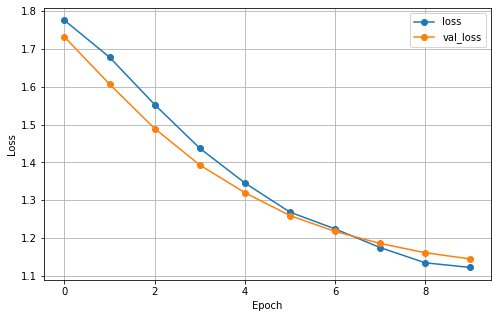

In [90]:
plt.plot(lstm_w2v.history['loss'], label='loss', marker = 'o')
plt.plot(lstm_w2v.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM classification with w2v

In [91]:
lstmW2V_pred = np.round(model.predict(x_test))

5/5 [==============================] - 3s 341ms/step


In [92]:
print('Accuracy %s' % accuracy_score(y_test, lstmW2V_pred))
print('F1-score %s' % f1_score(y_test, lstmW2V_pred, average=None))
print('Classification report:')
print(classification_report(y_test, lstmW2V_pred))

Accuracy 0.6201550387596899
F1-score [0.         0.76555024 0.         0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.62      1.00      0.77        80
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62       129
   macro avg       0.10      0.17      0.13       129
weighted avg       0.38      0.62      0.47       129
 samples avg       0.62      0.62      0.62       129



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#CNN Classification with Word2Vec

In [93]:
filters=10
kernel_size=3
epochs=20

In [94]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_lyrics_len, trainable=False, embeddings_initializer=Constant(embed_matrix)))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1886, 300)         4315500   
                                                                 
 conv1d_1 (Conv1D)           (None, 1884, 10)          9010      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                352       
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                      

In [95]:
cnn_w2v = model.fit(x_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle = True, 
                     validation_split=0.2, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
cnn_w2v

Epoch 1/20
7/7 [==============================] - 5s 664ms/step - loss: 1.8482 - accuracy: 0.3155 - val_loss: 1.2036 - val_accuracy: 0.5922
Epoch 2/20
7/7 [==============================] - 4s 618ms/step - loss: 1.2667 - accuracy: 0.5728 - val_loss: 1.0992 - val_accuracy: 0.5922
Epoch 3/20
7/7 [==============================] - 5s 647ms/step - loss: 1.1323 - accuracy: 0.5291 - val_loss: 1.0353 - val_accuracy: 0.5922
Epoch 4/20
7/7 [==============================] - 5s 656ms/step - loss: 1.1090 - accuracy: 0.5825 - val_loss: 1.0188 - val_accuracy: 0.5922
Epoch 5/20
7/7 [==============================] - 5s 666ms/step - loss: 1.0499 - accuracy: 0.5801 - val_loss: 1.0066 - val_accuracy: 0.5922
Epoch 6/20
7/7 [==============================] - 4s 581ms/step - loss: 1.0404 - accuracy: 0.5825 - val_loss: 0.9963 - val_accuracy: 0.5922
Epoch 7/20
7/7 [==============================] - 4s 630ms/step - loss: 1.0346 - accuracy: 0.5801 - val_loss: 0.9940 - val_accuracy: 0.5922
Epoch 8/20
7/7 [====

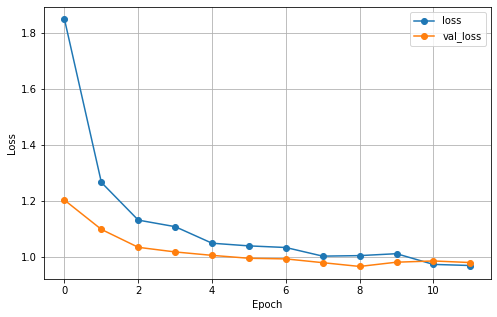

In [96]:
plt.plot(cnn_w2v.history['loss'], label='loss', marker = 'o')
plt.plot(cnn_w2v.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN classification with w2v

In [97]:
cnnW2V_pred = np.round(model.predict(x_test))

5/5 [==============================] - 0s 73ms/step


In [98]:
print('Accuracy %s' % accuracy_score(y_test, cnnW2V_pred))
print('F1-score %s' % f1_score(y_test, cnnW2V_pred, average=None))
print('Classification report:')
print(classification_report(y_test, cnnW2V_pred, zero_division=1))

Accuracy 0.5038759689922481
F1-score [0.04651163 0.75739645 0.         0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.05        42
           1       0.72      0.80      0.76        80
           2       1.00      0.00      0.00         3
           3       1.00      0.00      0.00         2
           4       1.00      0.00      0.00         2
           5       1.00      1.00      1.00         0

   micro avg       0.72      0.50      0.59       129
   macro avg       0.95      0.30      0.30       129
weighted avg       0.83      0.50      0.48       129
 samples avg       0.81      0.50      0.50       129



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
